# Information Retrieval and Web Analytics: Indexing + Modeling (TF-IDF) 

In [1]:
import time
import nltk
nltk.download('stopwords');
nltk.download('punkt') # used in sent_tokenize

from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import math
import numpy as np
import collections
from numpy import linalg as la
import json
import re
import csv
import sys
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib.pyplot import cm

from gensim.summarization.bm25 import BM25
import pandas as pd
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string

data_path = 'data/one100K_v2.json'

[nltk_data] Downloading package stopwords to C:\Users\David
[nltk_data]     Gayete\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\David
[nltk_data]     Gayete\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Preprocessing Data**

#### Load data into memory

The dataset ```dataset.jason``` contains a list of N tweets and its information. This dataset has ben made scrapping for tweets that contain any of the words "Trump", "#Trump", "Biden", "#Biden", "#UsElections2020".

In [2]:
docs_path = data_path
with open(docs_path) as fp:
    lines = fp.readlines()
tweets = [l.strip().replace(' +', ' ') for l in lines]

#### Clean Tweets
Preprocess the text of a concrete tweet removing non alphabetic characters, stop words, stemming, transforming in lowercase and return the tokens of the text.
    
    Argument:  tweetText -- string (text) to be preprocessed    
    Returns:   cleanText - a list of tokens corresponding to the tweetText after the preprocessing

In [3]:
def cleanTweet(tweetText):      
    stemming = PorterStemmer()
    stops = set(stopwords.words("english"))

    cleanText = tweetText.lower() ## Transform in lowercase
    cleanText = re.sub('[:\[\]&%$\"\'!./,;:?=¿^\-_*+)<>(¡]','',cleanText)
    cleanText = cleanText.split() ## Tokenize the text to get a list of terms
    cleanText = [word for word in cleanText if word not in stops]  ##eliminate the stopwords
    cleanText = [stemming.stem(word) for word in cleanText] ## perform stemming
    for i in range(len(cleanText)):
        if cleanText[i][0] == '@':
            cleanText[i] = str(hash(cleanText[i]))
    return cleanText

#### Crate a dictionary for each tweet
For each tweet, creates a dictionary containing the most relevant information of it (Username, OriginalText, Clean Tokens, number of Likes, number of retweets, list of URLs...)
    
    Argument:  tweet -- a JSON tweet content    
    Returns:   dictRelevantInfo -- a dictionary with the processed tweet

In [4]:
def getRelevantInfo(tweet):
    dictRelevantInfo ={}
    data = json.loads(tweet)
    hashtags = []
    urlsList = []
    text = ''
    date = data['created_at'] ## ??? RT o no RT
    try:
        isRt=True
        isRetweet=data["retweeted_status"]
        idTweet=isRetweet["id_str"]
        text = isRetweet['text']
        username = isRetweet['user']['screen_name']
        urls = isRetweet['entities']['urls']
        rt_count = isRetweet['retweet_count']
        likes = isRetweet['favorite_count']
        
        for h in isRetweet['entities']['hashtags']:
            hashtags.append(h['text'])
        for url in urls:
            urlsList.append(url['url'])
            
    except:
        isRt=False
        idTweet=data["id_str"]
        text = data['text']
        username = data['user']['screen_name']
        urls = data['entities']['urls']
        rt_count=data['retweet_count']
        likes = data['favorite_count']
        
        for h in data['entities']['hashtags']:
            hashtags.append(h['text'])
            
        for url in urls:
            urlsList.append(url['url'])        
            
    
    annonText=text.split()
    for i in range(len(annonText)):
        if annonText[i][0] == '@':
            annonText[i] = str(hash(annonText[i]))
    
    dictRelevantInfo['tweetID'] = idTweet
    dictRelevantInfo['text'] = " ".join(annonText)
    dictRelevantInfo['tokens'] = cleanTweet(text)
    dictRelevantInfo['username'] = username
    dictRelevantInfo['date'] = date
    dictRelevantInfo['hashtags'] = hashtags
    dictRelevantInfo['likes'] = likes
    dictRelevantInfo['rt_count'] = rt_count
    dictRelevantInfo['urlsList'] = urlsList
    dictRelevantInfo['isRetweeted'] = isRt
    return dictRelevantInfo

#### cleanTweets dict & Drop Duplicates
`Here we create a Dictionari (key::TweetID) of tweets. To do so, we iterate over the list of tweets from the dataset, preproces the tweet, and add it to the cleanTweets dictionary if it havent been added before (check for duplicates)`

In [5]:
cleanTweets = {}
for t in tweets:
    currentTweet = getRelevantInfo(t)
    tweetID = currentTweet['tweetID']
    # Orignial tweet found, add to the dict or overwrite if retweet already exist.
    if currentTweet['isRetweeted'] == False:
        cleanTweets[tweetID] = currentTweet
    else:
        if tweetID in cleanTweets:
            continue
        else:
            cleanTweets[tweetID] = currentTweet

In [6]:
print("Length of cleaned tweets: ",len(cleanTweets))

Length of cleaned tweets:  38592


## **Building the Search Engine**
    Argument:    terms -- list of query terms
                 docs -- list of documents, to rank, matching the query
                 index -- inverted index data structure
                 idf -- inverted document frequencies
                 tf -- term frequencies
                 titleIndex -- mapping between tweet id and tweet content
    
    Returns:     resultDocs -- list of tweetIDs in decreasing order and its score

### Creating tf-idf dictionary

Implement the inverted index and compute tf, df and idf



    Argument:   cleanTweets -- collection of tweets
                numTweets -- total number of tweets
    
    Returns:    index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
                list of document these keys appears in (and the positions) as values.
                tf - normalized term frequency for each term in each document
                df - number of documents each term appear in
                idf - inverse document frequency of each term

In [7]:
def create_index_tfidf(cleanTweets, numTweets):
    # lines -> cleanTweets
    # numDocs -> numOfTweets
        
    index=defaultdict(list)
    tf=defaultdict(list)        #term frequencies of terms in tweets
    df=defaultdict(int)         #document frequencies of terms in the corpus
    titleIndex=defaultdict(str)
    idf=defaultdict(float)

    tweetIndex=defaultdict(float)
    
    for line in cleanTweets.values(): # Remember, cleanTweets contain all tweets, each line is a tweet
        tweetID = line['tweetID']        
        terms = line['tokens']
        tweetIndex[tweetID]=line['text'] 

        termdictPage={}
        for position, term in enumerate(terms): ## terms contains all the tokens of the actual tweet
            try:
                # if the term is already in the dict append the position to the corrisponding list
                termdictPage[term][tweetID].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term]=[tweetID, array('I',[position])] #'I' indicates unsigned int (int in python)
        
        # normalize term frequencies
        # Compute the denominator to normalize term frequencies
        # norm is the same for all terms of a document.
        norm=0
        for term, posting in termdictPage.items(): 
            # posting is a list containing tweetID and the list of positions for current term in current tweet: 
            # posting ==> [tweetID, [list of positions]] 
            norm+=len(posting[1])**2
        norm=math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in termdictPage.items():     
            # append the tf for current term (tf = term frequency in current tweet/norm)
            tf[term].append(np.round(len(posting[1])/norm,4))
            #increment the tweet frequency of current term (number of tweets containing the current term)
            df[term]= len(termdictPage[term])  # increment df for current term
        
        #merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage)
            
    # Compute idf
    for term in df:
        idf[term] = np.round(np.log(float(numTweets/df[term])),4)
            
    return index, tf, df, idf, tweetIndex


In [8]:
start_time = time.time()
numTweets = len(cleanTweets)
index, tf, df, idf, tweetIndex = create_index_tfidf(cleanTweets, numTweets)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time,2)))

Total time to create the index: 4.01 seconds


In [9]:
def search_tf_idf(query, index, ranking_type = '0'):
    '''
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''
    query=cleanTweet(query)
    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            
            # docs = docs Union termDocs
            docs = docs.union(termDocs)
        except:
            #term is not in index
            pass
    docs=list(docs)
    if ranking_type == '0': # TF-IDF
        ranked_docs = rankDocuments_TFIDF(query, docs, index, idf, tf, tweetIndex)   
    elif ranking_type == '1': # TF-IDF + Likes + Retweets
        ranked_docs = rankDocuments_Likes_Retweets(query, docs, index, idf, tf, tweetIndex)
    return ranked_docs

In [10]:
def createLikeRTIndex(cleanTweets):
    # maxLikes = 0
    # maxRT = 1
    # for tweet in lines:
    #     if lines[tweet]['likes'] > maxLikes:
    #         maxLikes = lines[tweet]['likes']
    #     if lines[tweet]['rt_count'] > maxRT:
    #         maxRT = lines[tweet]['rt_count']
    for tweet in cleanTweets:
        cleanTweets[tweet]['likes_score'] = (-np.exp(-(cleanTweets[tweet]['likes']/50000))+1)
        cleanTweets[tweet]['rt_score'] = (-np.exp(-(cleanTweets[tweet]['rt_count']/25000))+1)

In [11]:
createLikeRTIndex(cleanTweets)

In [12]:
def rankDocuments_Likes_Retweets(terms, docs, index, idf, tf, titleIndex):
            
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
    docVectors=defaultdict(lambda: [0]*len(terms)) # I call docVectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary 
    queryVector=[0]*len(terms)    

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms) # get the frequency of each term in the query. 
    
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
                    
        ## Compute tf*idf(normalize tf as done with documents)
        queryVector[termIndex]=query_terms_count[term]/query_norm * idf[term]

        # Generate docVectors for matching docs
        for docIndex, (doc, postings) in enumerate(index[term]):
            
            if doc in docs:
                docVectors[doc][termIndex]=tf[term][docIndex] * idf[term]

    # calculate the score of each tweet
    # compute the cosine similarity between queyVector and each docVector:
       
    docScores=[ [(np.dot(curDocVec, queryVector)/(np.linalg.norm(curDocVec)*np.linalg.norm(queryVector)))*0.6+cleanTweets[doc]['likes_score']*0.2+cleanTweets[doc]['rt_score']*0.2, doc] for doc, curDocVec in docVectors.items() ]
    docScores.sort(reverse=True)
    resultDocs=[(x[0], x[1]) for x in docScores]
    #print document titles instead if document id's
    #resultDocs=[ titleIndex[x] for x in resultDocs ]
    if len(resultDocs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)    
    #print ('\n'.join(resultDocs), '\n')
    return resultDocs

In [13]:
def get_tokens(docs, preprocess=preprocess_string, verbose=10000):
    
    for i, doc in enumerate(docs):
        yield preprocess(doc) # preprocess
        
        # print progress if needed
        if verbose > 0 and (i + 1) % verbose == 0:
            print(f"Progress: {i + 1}")
            
def get_sentences(docs, verbose=10000):
    #loop over all docs (tweets in our case)
    for i, doc in enumerate(docs):
        
        # use nltk.sent_tokenize to split paragraphs into sentences
        for sentence in nltk.sent_tokenize(doc):
            # preprocess each sentence using gensim (return string not list)
            yield " ".join(preprocess_string(sentence))
            
        # print progress if needed
        if verbose > 0 and (i + 1) % verbose == 0:
            print(f"Progress: {i + 1}")

In [14]:
# Get all tweet TEXTS
tweets, tweetsID = [], []
for t in cleanTweets:
    tweets.append(cleanTweets[t]['text']) #add tweet to list of all tweets
    tweetsID.append(cleanTweets[t]['tweetID']) #add tweet id to list of all tweet ids

tokens = []
for t in cleanTweets:
    tokens.append(cleanTweets[t]['tokens'])
sentences = list(get_sentences(tweets))
#split each sentence into a list od words
words = [s.split() for s in sentences]
#create a word2Vec model  
MODEL_DIMENSION = 70
w2v_model = Word2Vec(sentences = words, size=MODEL_DIMENSION, window=10, min_count=1, negative=15, sg = 1)

Progress: 10000
Progress: 20000
Progress: 30000


In [15]:
def emb_vector(tweet, model=w2v_model):
    query_vec=[]
    i=0
    ## AQUI TENIEN EL TWEET EN TOKENS
    for word in tweet:
        if word in w2v_model.wv.vocab:
            query_vec.append(w2v_model.wv.word_vec(word))
            i+=1

    if i!=0:
        vec=np.average(np.array(query_vec), axis=0)
        return vec/np.linalg.norm(vec)

    #print(tweet)
    return np.zeros((MODEL_DIMENSION,))

In [16]:
embedded_tweets=[];
[embedded_tweets.append((emb_vector(cleanTweets[tweetID]['tokens']),tweetID)) for tweetID in cleanTweets];

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [17]:
fin=[vec[0] for vec in embedded_tweets]
low_dimension_embedded = TSNE(n_components=2, perplexity=2, random_state=33).fit_transform(fin)

[0 1 0 ... 0 0 1]


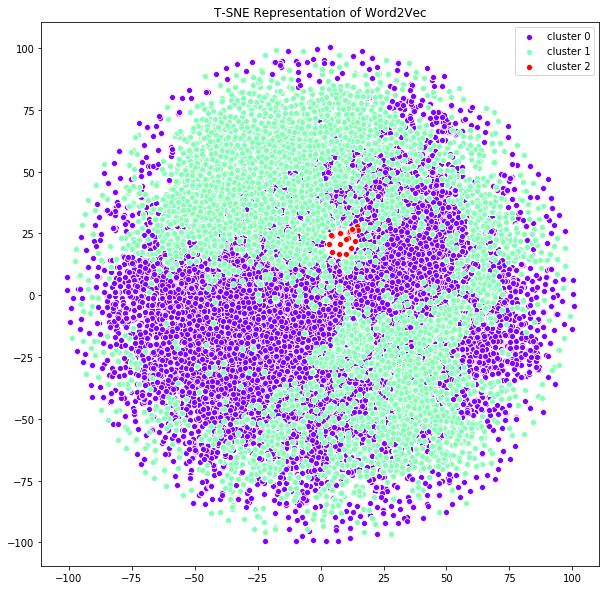

In [18]:
NUM_CLUSTERS=3

colors_list=cm.rainbow(np.linspace(0,1,NUM_CLUSTERS))

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(fin)
print(kmeans.labels_)


plt.figure(figsize=(10,10))
plt.title('T-SNE Representation of Word2Vec')

for i in range(0,NUM_CLUSTERS):
    
    sns.scatterplot(x=low_dimension_embedded[kmeans.labels_==i,0],y=low_dimension_embedded[kmeans.labels_==i,1],color=colors_list[i][0:3],label="cluster "+str(i))


#sns.scatterplot(x=low_dimension_embedded[:,0], y=low_dimension_embedded[:,1], legend='full',  c=kmeans.labels_)

#sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

plt.legend()
plt.show()

np.save('tsne_output_acabat.npy', low_dimension_embedded)
#low_dim_embedded=np.load('tsne_output_acabat.npy')

In [19]:
for i,tweetID in enumerate(cleanTweets):
    cleanTweets[tweetID]["cluster"]=kmeans.labels_[i]

In [20]:
centroids = kmeans.cluster_centers_
print(centroids.shape)

(3, 70)


In [21]:
### QUERY AMB EL NOSTRE == 1!!
print("Insert your query:\n")
query = input()
ranked_docs = search_tf_idf(query, index, ranking_type = '1')    
top = 10

contador=np.zeros(NUM_CLUSTERS)
diversity_score=[]

print("\n======================\nTop {} results out of {} for the seached query:\n".format(top, len(ranked_docs)))
for d_score, d_id in ranked_docs:
    cluster=cleanTweets[d_id]["cluster"]
    
    diversity_score.append((d_id,d_score*np.exp(-(contador[cluster]))))
    contador[cluster]+=1

diversity_score.sort(key=lambda tup: tup[1], reverse=True)

for d_id,d_score  in diversity_score[:top]:
    print("Tweet ID= {}\nTweet: {}\nScore: {}\nCluster: {}\n".format(d_id, tweetIndex[d_id], d_score,cleanTweets[d_id]["cluster"]))

Insert your query:

biden

Top 10 results out of 6273 for the seached query:

Tweet ID= 1331987171700510720
Tweet: Just saw the vote tabulations. There is NO WAY Biden got 80,000,000 votes!!! This was a 100% RIGGED ELECTION.
Score: 0.9963011245101722
Cluster: 1

Tweet ID= 1324158992877154310
Tweet: Today, the Trump Administration officially left the Paris Climate Agreement. And in exactly 77 days, a Biden Admini… https://t.co/7dT22UeN7h
Score: 0.9953960001543284
Cluster: 0

Tweet ID= 1331404288149643264
Tweet: Should President Trump concede to Biden? Poll Results: No: 190,593 (98.9%) Yes: 2,181 (1.1%) Total Votes: 192,774… https://t.co/VTeSnDblir
Score: 0.36195838541655245
Cluster: 1

Tweet ID= 1332155514386599937
Tweet: A must read. Impossible for Biden to have overcome these, and even greater, odds! https://t.co/cmYFY0va6p
Score: 0.35766595665618073
Cluster: 0

Tweet ID= 1332407714304110597
Tweet: Biden did poorly in big cities (Politico), except those of Detroit (more votes than peo